In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier


In [4]:
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, metrics, cv


In [5]:
from catboost.utils import get_gpu_device_count

use_gpu = False
if get_gpu_device_count():
    use_gpu = True


In [6]:
# Global notebook params (speed processing of stuff we want only once)
do_manual_svc = False
do_manual_bagging = False
do_sklearn_grid_tree = False
do_xgboost = True
do_catboost = True


In [7]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
defense = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'DEFENSE_stats.csv')
snaps = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'SNAP_COUNTS_stats.csv')

cleaned_matches = pd.read_csv(data)
# defense_stats = pd.read_csv(defense, index_col=[0,1,2])
# snaps_stats = pd.read_csv(snaps, index_col=[0,1,2])

In [8]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

In [9]:
cleaned_matches['Pct Team Score'] = cleaned_matches['Team Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])
cleaned_matches['Pct Opponent Score'] = cleaned_matches['Opponent Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])


## Train to classify based on the last-n-games a team played

In [10]:
x_cols = [
    'Team Code',
    'Opponent Code',
    'Location',
    'Home/Away'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Score Diff',
    'Pct Team Score',
    'Pct Opponent Score',
    'Location',
    'Home/Away'
]
key_x_cols = [
    'Team Code',
    'Opponent Code'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)


played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25914 entries, 0 to 26121
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Day                 25914 non-null  object        
 1   Date                25914 non-null  datetime64[ns]
 2   Home/Away           25914 non-null  object        
 3   Opponent            25914 non-null  object        
 4   Score               25914 non-null  object        
 5   W/L/T               25914 non-null  object        
 6   Overtime            948 non-null    object        
 7   Location            25914 non-null  object        
 8   Venue               25914 non-null  object        
 9   Attendance          25890 non-null  float64       
 10  Notes               1051 non-null   object        
 11  Opponent Code       25914 non-null  object        
 12  Team                25914 non-null  object        
 13  Team Code           25914 non-null  object    

In [11]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])


In [12]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, key_x_cols)


.................................................
 Done


In [13]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]

numeric_columns = X.columns[X.columns.str.contains('Score')]
categorical_columns = X.columns[~X.columns.str.contains('Score')]
categorical_columns_indices = np.where(~X.columns.str.contains('Score'))[0]

print(categorical_columns)
print(categorical_columns_indices)
print(numeric_columns)


Index(['Team Code', 'Opponent Code', 'Location', 'Home/Away',
       'Team Code_p_Location', 'Opponent Code_p_Location',
       'Team Code_pp_Location', 'Opponent Code_pp_Location',
       'Team Code_ppp_Location', 'Opponent Code_ppp_Location',
       'Team Code_pppp_Location', 'Opponent Code_pppp_Location',
       'Team Code_ppppp_Location', 'Opponent Code_ppppp_Location',
       'Team Code_p_Home/Away', 'Opponent Code_p_Home/Away',
       'Team Code_pp_Home/Away', 'Opponent Code_pp_Home/Away',
       'Team Code_ppp_Home/Away', 'Opponent Code_ppp_Home/Away',
       'Team Code_pppp_Home/Away', 'Opponent Code_pppp_Home/Away',
       'Team Code_ppppp_Home/Away', 'Opponent Code_ppppp_Home/Away'],
      dtype='object')
[ 0  1  2  3 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
      

In [14]:
X.head()


,Team Code,Opponent Code,Location,Home/Away,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,...,Team Code_p_Home/Away,Opponent Code_p_Home/Away,Team Code_pp_Home/Away,Opponent Code_pp_Home/Away,Team Code_ppp_Home/Away,Opponent Code_ppp_Home/Away,Team Code_pppp_Home/Away,Opponent Code_pppp_Home/Away,Team Code_ppppp_Home/Away,Opponent Code_ppppp_Home/Away
12,buf,cle,"Buffalo, NY",H,6.0,6.0,0.0,28.0,21.0,0.0,...,A,A,A,H,H,A,A,A,H,H
19,gb,chic,"Chicago, IL",A,16.0,16.0,3.0,3.0,3.0,3.0,...,H,H,A,A,H,H,A,A,H,H
23,min,chic,"Chicago, IL",A,3.0,3.0,6.0,3.0,7.0,16.0,...,H,H,A,A,H,H,A,A,H,H
25,chic,buf,"Chicago, IL",H,0.0,7.0,3.0,0.0,3.0,10.0,...,A,H,H,A,A,H,H,A,A,A
24,buf,chic,"Chicago, IL",A,9.0,9.0,7.0,0.0,0.0,3.0,...,H,H,H,A,A,H,H,A,A,H


In [15]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25778 entries, 12 to 26121
Data columns (total 74 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Team Code                               25778 non-null  object 
 1   Opponent Code                           25778 non-null  object 
 2   Location                                25778 non-null  object 
 3   Home/Away                               25778 non-null  object 
 4   Team Code_p_Team Score                  25778 non-null  float64
 5   Opponent Code_p_Team Score              25778 non-null  float64
 6   Team Code_pp_Team Score                 25778 non-null  float64
 7   Opponent Code_pp_Team Score             25778 non-null  float64
 8   Team Code_ppp_Team Score                25778 non-null  float64
 9   Opponent Code_ppp_Team Score            25778 non-null  float64
 10  Team Code_pppp_Team Score               25778 non-null  f

In [16]:
y.head()


,Class
12,1
19,0
23,0
25,1
24,0


In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(15466, 74) (15466, 1)
(5156, 74) (5156, 1)
(5156, 74) (5156, 1)


In [18]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])


In [19]:
def manual_grid_search_svc(do=True):
    if not do:
        return None
    best_model = None
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        train_scores = []
        val_scores = []
        val_space = np.geomspace(start=0.01, stop=5, num=3)
        for C in val_space:
            print(f"Evaluating {kernel} kernel for C={C}")
            model = make_pipeline(dataset_transformer(), svm.SVC(
                C=C, max_iter=10_000, kernel=kernel))

            model.fit(X_train, y_train.values.ravel())
            train_scores.append(model.score(X_train, y_train.values.ravel()))
            val_scores.append(model.score(X_val, y_val.values.ravel()))

            if best_model is None or val_scores[-1] == np.max(val_scores):
                best_model = model

        plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
        plt.plot(val_space, train_scores, label='Train score')
        plt.plot(val_space, val_scores, label='Val score')
        # plt.ylim(0, 1.1)
        plt.xscale('log')
        plt.legend()
        plt.show()
    return best_model


best_model = manual_grid_search_svc(do_manual_svc)


In [20]:
if best_model is not None:
    y_pred = best_model.predict(X_test)
    precision, recall, fbeta_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
    print(precision, recall, fbeta_score)


In [21]:
def manual_grid_bagging(do=True):
    if not do:
        return [], [], 0, 0
    best_config = []
    best_score = 0
    best_fit_config = []
    best_fit_score = 0
    for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=10), DecisionTreeClassifier(max_leaf_nodes=50), DecisionTreeClassifier()]:
        for nestimators in [10, 31, 62, 93, 124, 200, 300, 400, 500]:
            for nsamples in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6]:
                clf = make_pipeline(dataset_transformer(), BaggingClassifier(
                    base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
                clf.fit(X_train, y_train.values.ravel())

                score = clf.score(X_val, y_val.values.ravel())
                if(score > best_score):
                    best_config = [estimator, nestimators, nsamples]
                    best_score = score

                score = clf.score(X_train, y_train)
                if(score > best_fit_score):
                    best_fit_config = [estimator, nestimators, nsamples]
                    best_fit_score = score

                print(end='.')
    return best_config, best_fit_config, best_score, best_fit_score


best_config, best_fit_config, best_score, best_fit_score = manual_grid_bagging(
    do_manual_bagging)


In [22]:
model = {
    'model': BaggingClassifier,
    'kwargs': {'base_estimator': DecisionTreeClassifier()},
    'cross_vals': 5,
    'param_grid': {
        'bagging_clf__base_estimator__max_leaf_nodes': np.linspace(2, 100, num=20, dtype=int),
        'bagging_clf__max_samples': np.linspace(0.01, 0.8, 10),
        'bagging_clf__n_estimators': np.geomspace(10, 1000, num=20, dtype=int)
    }
}

pipe = Pipeline([('column_transformer', dataset_transformer()),
                 ('bagging_clf', model['model'](**model['kwargs']))])

print(model)

grid_search_bag_tree = model_selection.GridSearchCV(
    pipe, param_grid=model['param_grid'], cv=model['cross_vals'], n_jobs=11, refit=True, verbose=3)


{'model': <class 'sklearn.ensemble._bagging.BaggingClassifier'>, 'kwargs': {'base_estimator': DecisionTreeClassifier()}, 'cross_vals': 5, 'param_grid': {'bagging_clf__base_estimator__max_leaf_nodes': array([  2,   7,  12,  17,  22,  27,  32,  38,  43,  48,  53,  58,  63,
        69,  74,  79,  84,  89,  94, 100]), 'bagging_clf__max_samples': array([0.01      , 0.09777778, 0.18555556, 0.27333333, 0.36111111,
       0.44888889, 0.53666667, 0.62444444, 0.71222222, 0.8       ]), 'bagging_clf__n_estimators': array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])}}


In [23]:
if do_sklearn_grid_tree:
    grid_search_bag_tree.fit(X_train, y_train.values.ravel())
    grid_search_bag_tree.cv_results_


In [24]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")

if do_sklearn_grid_tree:
    plt.hist(grid_search_bag_tree.best_estimator_.predict_proba(X_test))


Best validation: 0, []
Best training: 0, []


In [25]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train)
clf.score(X_val, y_val)


0.7492242048099301

(array([[2561.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2595.],
        [2595.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2561.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

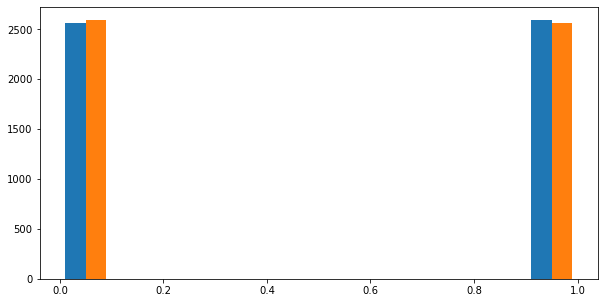

In [26]:
plt.hist(clf.predict_proba(X_test))


In [27]:
if do_manual_svc:
    Cs = np.geomspace(0.01, 15, num=75)
    scores = []
    for c in Cs:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))
        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=5))
        print(end='.')


...........................................................................

In [28]:
if do_manual_svc:
    x = Cs
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [29]:
if do_manual_svc:
    print('Maximum mean:', np.max(np.mean(scores, axis=1)))
    print('Corresponding std deviation:', np.std(
        scores, axis=1)[np.argmax(np.mean(scores, axis=1))])
    print('C:', Cs[np.argmax(np.mean(scores, axis=1))])


In [30]:
if do_manual_svc:
    print('Minimum std deviation:', np.min(np.std(scores, axis=1)))
    print('Corresponding mean:', np.mean(scores, axis=1)
          [np.argmin(np.std(scores, axis=1))])
    print('C:', Cs[np.argmin(np.std(scores, axis=1))])


In [31]:
if do_manual_svc:
    best_mean_cs = np.flip(np.argsort(np.mean(scores, axis=1)))
    best_std_cs = np.argsort(np.std(scores, axis=1))


In [32]:
if do_manual_svc:
    # Do some random perturbation of the Cs
    scores = []

    Cs_to_examine = np.unique(np.concatenate(
        (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
    Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(
        Cs_to_examine + np.random.normal(scale=0.2, size=len(Cs_to_examine)))]))

    for c in Cs_to_examine:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))

        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=100, n_jobs=-1))

        print(end='.')


In [33]:
if do_manual_svc:
    x = Cs_to_examine
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [34]:
if do_manual_svc:
    best_mean_idx = np.argmax(np.mean(scores, axis=1))

    print(
        f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')


In [35]:
if do_manual_svc:
    # Train the best model.

    model = make_pipeline(dataset_transformer(),
                          svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
    model.fit(X_cv, y_cv.values.ravel())
    model.score(X_test, y_test.values.ravel())


In [36]:
if do_manual_svc:
    coefs = model[1].coef_[0]
    plt.scatter(x=np.arange(len(coefs)), y=coefs)
    plt.show()


In [37]:
if do_manual_svc:
  model.fit(X, y.values.ravel())
  confidences = model.decision_function(X)


In [38]:
if do_manual_svc:
    plt.hist(confidences, bins=25)
    plt.show()


In [39]:
if do_manual_svc:
    plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)
    plt.show()


In [40]:
if do_manual_svc:
    np.min(confidences * (2 * y.to_numpy().ravel() - 1))


In [41]:
if do_catboost:
    model = CatBoostClassifier(
        custom_loss=[metrics.Accuracy()],
        random_seed=0xdeadbeef,
        logging_level='Silent',
        task_type='GPU' if use_gpu else 'CPU'
    )

    model.fit(
        X_cv, y_cv,
        cat_features=categorical_columns_indices,
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        plot=True
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
if do_catboost:
    data_pool = Pool(X_cv, y_cv, cat_features=categorical_columns_indices)
    cv_params = model.get_params()
    cv_params.update({
        'loss_function': metrics.Logloss()
    })
    cv_data = cv(
        data_pool,
        cv_params,
        plot=True,
        early_stopping_rounds=100
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
if do_catboost:
    print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
        np.max(cv_data['test-Accuracy-mean']),
        cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
        np.argmax(cv_data['test-Accuracy-mean'])
    ))
    print()
    
    feature_importances = model.get_feature_importance(data_pool)
    feature_names = X_train.columns
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        print('{}: {}'.format(name, score))


Best validation accuracy score: 0.79±0.00 on step 501

Opponent Code_p_Pct Opponent Score: 18.182744764179294
Team Code_p_Pct Team Score: 15.067524819610128
Team Code_p_Score Diff: 14.994590480404742
Team Code_pp_Location: 8.596404491709542
Team Code_ppp_Location: 7.014819425362725
Opponent Code_p_Pct Team Score: 5.227960511570593
Team Code_p_Location: 4.6912828831917555
Opponent Code_p_Location: 3.440062862077084
Opponent Code_p_Score Diff: 3.3328014668823847
Team Code_p_Pct Opponent Score: 3.180526290307309
Team Code_pppp_Location: 2.7807355476005773
Opponent Code_pp_Location: 2.263915241334354
Team Code_ppppp_Location: 2.0307377028431275
Location: 1.8621542102387745
Opponent Code_pppp_Location: 1.7557100389213667
Opponent Code_ppppp_Location: 1.7326586664098198
Home/Away: 1.022394170054911
Opponent Code_ppp_Location: 0.8775517535713394
Team Code: 0.7344587801479019
Opponent Code: 0.6144461759831371
Opponent Code_ppppp_Team Score: 0.08565291430497918
Team Code_pp_Score Diff: 0.081695

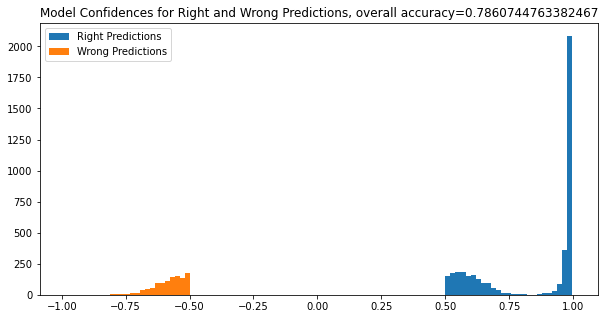

In [44]:
if do_catboost:
    confidences = model.predict_proba(X_test)
    confidences = np.max(confidences, axis=1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
    wrong_preds = confidences[confidences < 0]
    right_preds = confidences[confidences > 0]
    plt.title(f'Model Confidences for Right and Wrong Predictions, overall accuracy={model.score(X_test, y_test.values.ravel())}')
    plt.hist(right_preds, bins=25, label='Right Predictions')
    plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
    plt.legend()
    plt.show()


Train accuracy=0.9571331587624866


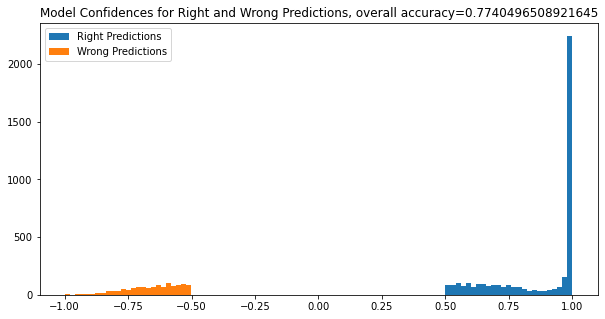

In [45]:
if do_xgboost:
  model = make_pipeline(dataset_transformer(),xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss'))
  model.fit(X_cv, y_cv.values.ravel())
  print(f'Train accuracy={model.score(X_cv, y_cv.values.ravel())}')
  
  confidences = model.predict_proba(X_test)
  confidences = np.max(confidences, axis=1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
  wrong_preds = confidences[confidences < 0]
  right_preds = confidences[confidences > 0]
  plt.title(f'Model Confidences for Right and Wrong Predictions, overall accuracy={model.score(X_test, y_test.values.ravel())}')
  plt.hist(right_preds, bins=25, label='Right Predictions')
  plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
  plt.legend()
  plt.show()